# Intercambio de brazaletes

El intercambio de brazaletes es una actvidad que se ha vuelto muy popular en los últimos meses en conciertos. Consiste en realizar brazaletes con temáticas relacionadas al cantante, ya sea las iniciales de alguna de sus canciones o una frase icónica de esa persona. Los fans van a los conciertos con estos brazaletes y los intercambian entre si, ya sea por diseños que les gusten más, para conseguir alguno en específico, o solo por diversión.
En una sala de cine se va a transmitir un concierto. Los fans están muy emocionados por poder llevar a cabo esta dinámica en la sala de cine, no obstante al ser un cine esta actividad se llevará a cabo de una manera más controlada, con el fin de brindar una maravillosa experiencia a todos los que asistan, que se puedan intercambiar los brazaletes, además de que puedan disfrutar la película y pasar un buen rato.
Esta es una simulación que muestra esta actividad basada desde El Juego de la Vida del matemático John Horton Conway.



<center>
<img src="https://i.etsystatic.com/22925573/r/il/1a0dd2/4899550808/il_fullxfull.4899550808_387n.jpg" width=250 height=300 />
</center>

## Reglas

El entorno en donde se realiza esta actividad, cuadrícula ortogonal bidimensional de celdas cuadradas, cada una de ellas se encuentra en alguno de los 3 posibles estados: Regalando brazaletes, pidiendo brazaletes, o disfrutando la película.
Cada celda interactúa con ocho vecinos, que son las celdas adyacentes horizontales, verticales y diagonales. En cada paso de tiempo, las siguientes transiciones ocurren:

1. Las personas(celdas) llegan a la sala de cine con entre 0 y 20 pulseras.
2. Las personas con menos de 10 brazaletes (0 - 9) pueden pedir a otra persona que les regale una.
3. Las personas con más de 10 brazaletes (11 - 20) pueden regalar brazaletes a otra persona.
4. Las personas que tienen 10 pulseras exactamente se sientan a disfrutar la película, ya no intercambian brazaletes.  

El patrón inicial constituye la semilla del sistema. La cantidad de brazaletes de las primeras personas que llegan a la sala de cine es creada al aplicar las reglas anteriores de manera simultánea a cualquier celda, y el momento discreto en el que obtienen/pierden un brazalete es llamado turno. Cada generación es una función pura de la anterior. Las reglas se aplican de forma repetida para crear nuevas generaciones.


In [ ]:
!python3 -m pip install mesa

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [ ]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

## Crear el modelo

Antes que nada el presente modelo se encuentra basado en el [tutorial introductorio](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html). Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [ ]:
#Estados: Recibiendo = 1, Regalando = 2, Viendo = 3

class CinemaVisitorAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.pulseras = np.random.randint(0, 21)  # Número aleatorio de pulseras de 1 a 15
        self.state = None

    def step(self):

      if self.pulseras > 10:
        self.state = 2
      if self.pulseras < 10:
        self.state = 1
      if self.pulseras == 10:
        self.state = 3


      neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)

      donatingNeighbors = [neighbor for neighbor in neighbours if neighbor.state == 2]
      requestingNeighbors = [neighbor for neighbor in neighbours if neighbor.state == 1]

      match self.state:
        case 1: #recibiendo pulseras
          for neighbor in donatingNeighbors:
            if self.pulseras < 10:
              self.pulseras += 1
              neighbor.pulseras -= 1

        case 2: #pidiendo pulseras:
          for neighbor in requestingNeighbors:
            if self.pulseras > 10:
              self.pulseras -= 1
              neighbor.pulseras += 1

        case 3:
          return

class GameLifeModel(Model):
    """
    Define el modelo del juego de la vida.
    """
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        # se importa arriba: import random
        # celdas = model.grid.coord_iter()
        # celdas_con_arboles = random.sample(celdas, k=25)
        # posiciones_arboles = [pos for _, pos in celdas_con_arboles]

        for (content, pos) in self.grid.coord_iter():
            # if pos in posiciones_arboles
                # código para instanciar árbol

            a = CinemaVisitorAgent(pos, self)
            self.grid.place_agent(a, pos)
            self.schedule.add(a)

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "Pulseras": self.get_pulseras}
        )

    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, pos = cell
            x, y = pos
            grid[x][y] = cell_content.pulseras

        return grid

    def get_pulseras(self):
        total_pulseras_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, _ = cell
            if isinstance(agent, CinemaVisitorAgent):
                total_pulseras_agents += agent.pulseras

        return total_pulseras_agents

# Ejecución del modelo
A continuación corremos el modelo

In [ ]:
# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 50

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

model = GameLifeModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:02.559250


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [ ]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [ ]:
all_grids

In [ ]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

colors = []
colors.append(np.array([255 / 255, 255 / 255, 40 / 255, 1])) #amarillo - Recibiendo
colors.append(np.array([255 / 255, 80 / 255, 80 / 255, 1])) #rojo - Viendo
colors.append(np.array([120 / 255, 255 / 255, 120 / 255, 1])) #verde - Regalando
#colors.append(np.array([40 / 255, 40 / 255, 40 / 255, 1]))
colormap = mlp.colors.ListedColormap(colors)

patch_grid = axs.imshow(all_grids['Grid'].iloc[0], cmap=colormap, vmin=0, vmax=20)

pulseras = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])
    pulseras.append(all_grids['Pulseras'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [ ]:
anim

##**Gráficas**

A continuación se pueden observar dos gráficas que modelan el comportamiento de esta actividad. En estas gráficas se están comparando los estados de Regalar y Pedir brazaletes con el paso de tiempo, cada estado en su respectiva gráfica. Lo que se observa en estas gráficas es como a medida que avanza el tiempo se van disminuyendo la cantidad de personas que están regalando/pidiendo brazaletes. Esto nos lleva a concluir que para el final de la película, la myoría de la sala va a tener 10 pulseras y va a estar disfrutando de la película.

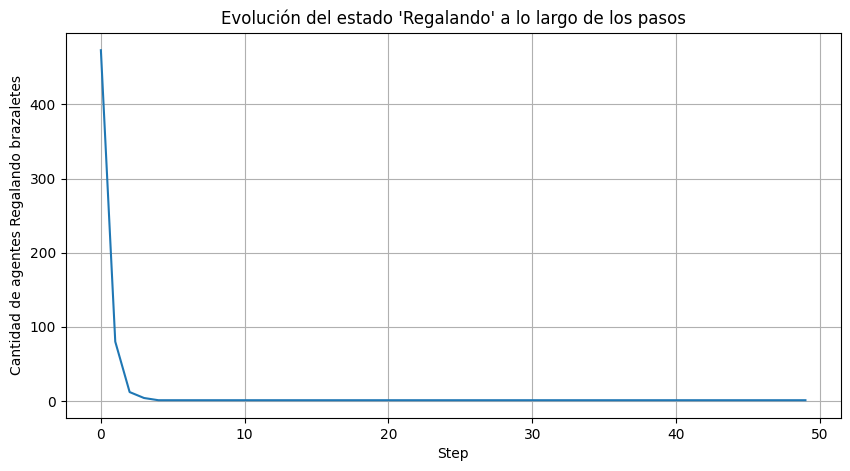

In [ ]:
regalando_data = all_grids['Grid'].apply(lambda grid: (grid == 2).sum().sum())

plt.figure(figsize=(10, 5))
plt.plot(regalando_data.index, regalando_data.values)

plt.xlabel("Step")
plt.ylabel("Cantidad de agentes Regalando brazaletes")
plt.title("Evolución del estado 'Regalando' a lo largo de los pasos")

plt.grid(True)
plt.show()


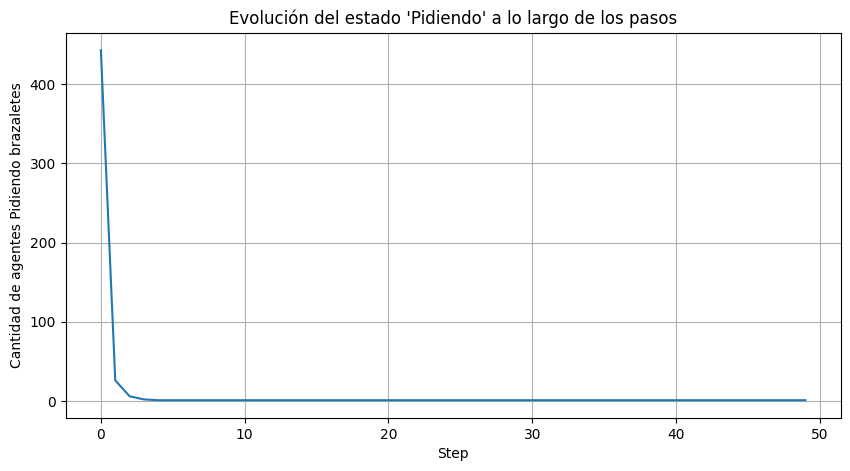

In [ ]:
pidiendo_data = all_grids['Grid'].apply(lambda grid: (grid == 1).sum().sum())

plt.figure(figsize=(10, 5))
plt.plot(pidiendo_data.index, pidiendo_data.values)

plt.xlabel("Step")
plt.ylabel("Cantidad de agentes Pidiendo brazaletes")
plt.title("Evolución del estado 'Pidiendo' a lo largo de los pasos")

plt.grid(True)
plt.show()
